# Reservoir Operations Spain - attributes
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 13-03-2024<br>

**Introduction:**<br>
This code compares the available attributes for reservoirs in Spain from different sources: the Spanish Ministry, ICOLD, GRanD.

**To be checked:**<br>
* [ ] The field `cedex_dam.Qspill_EFL` is mostly empty.
* [ ] There's a erroneous reservoir in EFAS. "El Alisillo" (ResID=3247) does not refer to any real reservoir, but it's very closely located to the "Montoro III" reservoir. The attributes don't much, though, so it's not a matter of just renaming the reservoir.
* [ ] How to proceed when there are several reservoirs in a continuous chain. For instance, Torrejón-Tajo and Arrocampo, or Tanes and Rioseco. Should we simulate each of them, or simply simulate them as a single reservoir with the aggregated volume?
* [ ] Attributes from GRanD
* [ ] Compare attributes among data sources: reservoir volume, etc.

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Point
import re
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('ticks')

## Configuration

In [94]:
path_datasets = Path('Z:/nahaUsers/casadje/datasets')

path_ResOpsES = path_datasets / 'reservoirs' / 'ResOpsES'

## Hydrological Data Colection Centre (HDCC)

Import CSV file of reservoirs in the Hydrological Data Colection Center (HDCC) database, fix some reservoir names and export it as a shapefile.

```Python
reservoirs = pd.read_csv(list(path.glob('*.csv'))[0], sep=';', index_col='EFAS_ID')

# correct reservoir names
names = []
for name in reservoirs.Name:
    name = name.upper()
    # remove code from reservoir name
    name = re.sub(r'E\d{2}\s*', '', name)
    # remove string 'embalse' from name
    name = re.sub(r'EMBALSE DE\s+', '', name)
    name = re.sub(r'EMBALSE DEL\s+', 'EL ', name)
    # remove string at the of the name
    name = re.sub(r'\s*\(PIE DE PRESA\)', '', name)
    # place articles ('el', 'la'...) at the beginning
    name = re.sub(r'(\w+), (\w+)', r'\2 \1', name)
    names.append(name)
reservoirs.Name = names

# convert into GeoDataFrame
geometry = [Point(xy) for xy in zip(reservoirs.Longitude_WGS84, reservoirs.Latitude_WGS84)]
reservoirs = gpd.GeoDataFrame(reservoirs, geometry=geometry, crs='epsg:4326')

print('total no. reservoirs:\t\t\t{0}'.format(reservoirs.shape[0]))

reservoirs.to_file('Z:/nahaUsers/casadje/datasets/hDMS/reservoirs/reservoirs.shp')
```

In [54]:
# import shapefile
hdcc = gpd.read_file(path_datasets / 'hDMS/reservoirs/reservoirs.shp')

# filter reservoirs from the Spanish Ministry
hdcc = hdcc.loc[hdcc['Country-Co'] == 'ES'].copy()
hdcc = hdcc.loc[hdcc.Prov_ID == '1088']

# rename ID fields and set index
hdcc.rename(columns={'National_S': 'Local_ID', 'EFAS_ID': 'HDCC_ID'}, inplace=True)
hdcc[['Local_ID', 'HDCC_ID']] = hdcc[['Local_ID', 'HDCC_ID']].astype(int)
hdcc.set_index('Local_ID', drop=True, inplace=True)

print(hdcc.shape)

(394, 141)


The table `reservoirs` in HDCC does not contain reservoir attributes of interest (volume, area, catchment area, height, use...). I will only use this table to map reservoir IDs in EFAS and in the dataset of the Spanish Ministry.

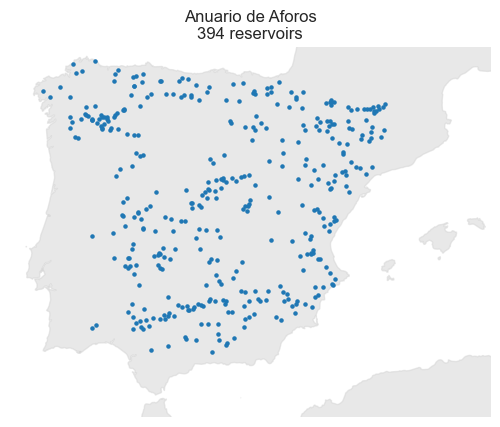

In [55]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
hdcc.plot(markersize=5, ax=ax)
ax.set_title(f'Anuario de Aforos\n{hdcc.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');

## CEDEX

In [17]:
path_cedex = path_datasets / 'CEDEX' / 'processed' / 'reservoirs' 

### Reservoir attributes

There are several attributes of interest in this table:

* Coordinates.
* Reservoir volume: both total and live volume.
* Reservoir area.
* Design reservoir levels.


In [7]:
cedex_res = pd.read_csv(path_cedex / 'attributes' / 'attributes_reservoirs.csv', index_col='ref_ceh')
cedex_res.index.name = 'Local_ID'
cedex_res['Código del embalse'] = cedex_res['Código del embalse'].astype(int)

rename_cols = {'Código del embalse': 'res_ID',
               'Nombre del embalse': 'res_name',
               'Titular del embalse': 'owner',
               'Coord. X ETRS89': 'lon', # longitude
               'Coord. Y ETRS89': 'lat', # latitud
               'Coord. X UTM ETRS89 Huso 30': 'X',
               'Coord. Y UTM ETRS89 Huso 30': 'Y',
               'Coord. X Manual': 'X_manual',
               'Coord. Y Manual': 'Y_manual',
               'Volumen útil (m3)': 'V_live',
               'Volumen total (m3)': 'V_total',
               'Superficie del embalse (has)': 'sup',
               'Máximo nivel de avenida (m)': 'EFL', # Extreme Flood Level
               'Máximo nivel normal del embalse (m)': 'MNL', # Maximum Normal Level
               'Municipio': 'town', 
               # 'Id. Hoja 1:50.000',
               'Cauce': 'river', 
               'Código de infraestructura': 'inf_ID', 
               'Nombre de la presa': 'dam_name'}

cedex_res.rename(columns=rename_cols, inplace=True)

### Dam attributes

This dataset contains multiple attributes of interes:

* Date of construction.
* Coordinates.
* Reservoir use.
* Catchment area.
* Reservoir level, surface and volume at the maximum normal level (MNL).
* Elevation of river, foundation, crest.
* Number of outlets (spillways and sluices) and their discharge capacity.

In [73]:
cedex_dam = pd.read_csv(path_cedex / 'attributes' / 'attributes_dams.csv', index_col='ref_ceh')
cedex_dam.index.name = 'Local_ID'

# rename columns
rename_cols = {'Nombre de la presa': 'dam_name',
               'Otro Nombre': 'other_name',
               'Fase vida presa': 'phase',
               'Titular de la presa': 'owner',
               'Proyectista': 'designer',
               'Categoría en función del riesgo potencial': 'category',
               'Aprobación de las normas de explotación': 'date_exploitation_plan',
               'Aprobación del plan de emergencia': 'date_emergency_plan',
               'Fecha de finalización de las obras': 'date_construction',
               'Río en el que se encuentra la presa': 'river', 
               'Municipio': 'town',
               'Cuenca hidrográfica': 'basin', 
               'Provincia': 'province', 
               'X-UTM30ETRS89': 'X', 
               'Y-UTM30ETRS89': 'Y',
               'Usuarios': 'users', 
               'Tipos': 'use', 
               'Superficie de la cuenca hidrográfica (km2)': 'catch_area',
               'Aportación media anual (hm3)': 'inflow', 
               'Precipitación media anual (mm)': 'precip',
               'Caudal punta avenida de proyecto (m3/s)': 'Q_design',
               'Superficie del embalse a NMN (ha)': 'A_MNL', # Nivel Máximo Normal => Maximum Normal Level
               'Capacidad a NMN (hm3)': 'V_MNL',
               'Cota del NMN (m)': 'Z_MNL', 
               'Tipo de presa': 'type', 
               'Cota coronación (m)': 'Z_crest',
               'Altura desde cimientos (m)': 'height', 
               'Longitud de coronación (m)': 'len_crest',
               'Cota cimentación (m)': 'Z_foundation', 
               'Cota del cauce en la presa (m)': 'Z_river',
               'Volumen del cuerpo presa (1000 m3)': 'dam_vol',
               'Número total de aliviaderos en la presa': 'no_spill', 
               'Regulación': 'regulation',
               'Capacidad a NAE (m3/s)': 'Qspill_EFL', # Nivel de Avenida Extrema => Extreme Flood Level
               'Número total de desagües en la presa': 'no_sluice',
               'Capacidad (m3/s)': 'Qsluice'}
cedex_dam.rename(columns=rename_cols, inplace=True)

# convert to date
for col in cedex_dam.columns[cedex_dam.columns.str.startswith('date')]:
    cedex_dam[col] = pd.to_datetime(cedex_dam[col], format='%d-%m-%Y', errors='coerce')

# analyse reservoir use:
# 1. I will suppose that the the first use in the dataset is the `main_use`
# 2. I create a `single_use` field to identify single-purpose and multipurpose reservoirs
# 3. I create a one hot encoder class with all the possible reservoir uses

cedex_dam.use = cedex_dam.use.replace(np.nan, '')

rename_uses_cedex = {'': 'other',
                     'Abastecimiento': 'supply',
                     'Acuicultura': 'aquaculture',
                     'Adecuación ambiental': 'environment',
                     'Defensa frente avenidas': 'flood',
                     'Ganadero': 'livestock',
                     'Hidroeléctrico': 'hydropower',
                     'Industrial': 'industry',
                     'Minería': 'mining',
                     'Recreo': 'recreational',
                     'Regulación': 'regulation',
                     'Riego': 'irrigation',
                     'Trasvase': 'diversion'}

cedex_dam['main_use'] = ''
cedex_dam['single_use'] = True
uses = list(rename_uses_cedex.values())
# uses.remove('')
uses.sort()
cedex_dam[uses] = False
for ID in cedex_dam.index:
    uses_i = cedex_dam.loc[ID, 'use'].split('. ')
    # if '' in uses_i:
    #     uses_i.remove('')
    if len(uses_i) > 0:
        for i, use in enumerate(uses_i):
            use = rename_uses_cedex[use]
            if i == 0:
                cedex_dam.loc[ID, 'main_use'] = use
            cedex_dam.loc[ID, use] = True

# identify multi-purpose reservoirs
mask_multiuse = cedex_dam[uses].sum(axis=1) > 1
cedex_dam.loc[mask_multiuse, 'single_use'] = False

# remove original 'use' field
# cedex_dam.drop('use', axis=1, inplace=True)

### Reservoir use
**Main use**

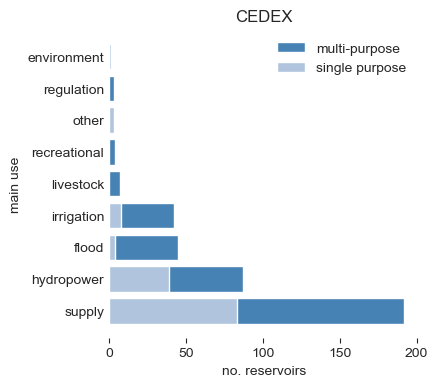

In [9]:
mainuse_singlepurpose = cedex_dam.loc[cedex_dam.single_use, 'main_use'].value_counts()
mainuse_multipurpose = cedex_dam['main_use'].value_counts()
mainuse_summary_cedex = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_cedex.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_cedex.sort_values('multipurpose', ascending=False, inplace=True)


fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(mainuse_summary_cedex.index, mainuse_summary_cedex.multipurpose, color='steelblue', label='multi-purpose')
ax.barh(mainuse_summary_cedex.index, mainuse_summary_cedex.singlepurpose, color='lightsteelblue', label='single purpose')
ax.set(title='CEDEX',
       xlabel='no. reservoirs',
       ylabel='main use')
ax.tick_params(axis='y', length=0)
ax.legend(loc=1, frameon=False)
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);
# plt.savefig(path_out / 'reservoir_main_use.jpg', dpi=300, bbox_inches='tight');

**All uses**

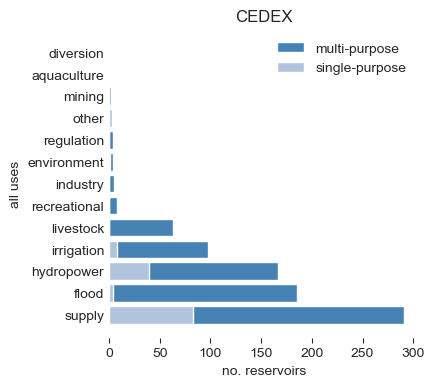

In [10]:
alluses_singlepurpose = cedex_dam.loc[cedex_dam.single_use, uses].sum()
alluses_multipurpose = cedex_dam[uses].sum()
alluses_summary_cedex = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_cedex.columns = ['singlepurpose', 'multipurpose']
alluses_summary_cedex.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_cedex.dropna(axis=0, how='all', inplace=True)

fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(alluses_summary_cedex.index, alluses_summary_cedex.multipurpose, color='steelblue', label='multi-purpose')
ax.barh(alluses_summary_cedex.index, alluses_summary_cedex.singlepurpose, color='lightsteelblue', label='single-purpose')
ax.set(title='CEDEX',
       xlabel='no. reservoirs',
       ylabel='all uses')
ax.tick_params(axis='y', length=0)
ax.legend(loc=1, frameon=False)
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);

**Classify hydropower reservoirs**

I will create a field called `HP_type` (hydropower type) to specify the importance of the hydropower use among all the uses of that reservoir. Codes:

* 0: single purpose hydropower.
* 1: multi-purpose in which hydropower is the main use.
* 2: multi-purpose in which hydropower is the second use.
* 3: multi-purpose in which hydropower is the third use.
* N: multi-purpose in which hydropower is the Nth use.

In [11]:
cedex_dam['HP_type'] = np.nan

In [12]:
cedex_dam.loc[cedex_dam.single_use & cedex_dam.hydropower, 'HP_type'] = 0

In [13]:
for ID in cedex_dam.loc[cedex_dam.hydropower].index:
    if cedex_dam.loc[ID, 'single_use']:
        continue
    uses = [rename_uses_cedex[use] for use in cedex_dam.loc[ID, 'use'].split('. ')]
    if 'hydropower' in uses:
        cedex_dam.loc[ID, 'HP_type'] = uses.index('hydropower') + 1

In [14]:
cedex_dam.HP_type.value_counts()

2.0    50
1.0    48
0.0    39
4.0    17
3.0    12
5.0     1
Name: HP_type, dtype: int64

**Total annual volume outflow (hm3)**

In [15]:
outflows = pd.DataFrame(dtype=float)
for ID in tqdm(cedex_dam.loc[cedex_dam.hydropower].index):
    
    # load time series
    df = pd.read_csv(path_cedex / 'timeseries' / f'{ID}.csv', index_col='date')
    df.index = pd.to_datetime(df.index)
    if 'outflow' not in df.columns:
        continue
    
    # compute annual total flow
    outflow_y = df.loc[datetime(2010, 1, 1): datetime(2019, 12, 31), 'outflow'].resample('y').mean() * 365 * 24 * 3600 / 1e6
    outflow_y.index = [f'outflow_{idx.year}' for idx in outflow_y.index]
    outflow_y = outflow_y.to_frame(ID)
    
    # concatenate
    outflows = pd.concat((outflows, outflow_y), axis=1)

  0%|          | 0/167 [00:00<?, ?it/s]

### Connect HDCC and CEDEX
The connection is direct using the common `Local_ID` field in both the HDCC and CEDEX data sets.

In [90]:
# columns to be used from HDCC
cols_hdcc = ['HDCC_ID', 'Name']

# columns to be used from the inventory of dams in CEDEX
cols_cedex_dam = ['date_construction',
                  # catchment hydrology
                  'catch_area', 'inflow', 'precip', 'Q_design', 
                  # reservoir geometry
                  'A_MNL', 'V_MNL', 'Z_MNL', 'Z_crest', 'height', #'dam_vol', 
                  # reservoir regulation
                  'no_spill', 'Qspill_EFL', 'regulation', 'no_sluice', 'Qsluice',
                  # reservoir use
                  'main_use', 'single_use', 'aquaculture', 'diversion', 'environment', 'flood', 'hydropower', 'industry', 'irrigation', 'livestock',
                  'mining', 'other', 'recreational', 'supply']

# columns to be used from the inventory of reservoirs in CEDEX
cols_cedex_res = ['V_live', 'V_total', 'sup', 'EFL', 'MNL']

In [92]:
# combine attributes from HDCC and CEDEX
attributes_cedex = pd.concat((hdcc[cols_hdcc], cedex_dam[cols_cedex_dam], cedex_res[cols_cedex_res]), axis=1).sort_index(axis=1)

### Export

In [97]:
# attributes
path_out = path_ResOpsES / 'attributes'
path_out.mkdir(parents=True, exist_ok=True)
attributes_cedex.to_csv(path_out / 'attributes_CEDEX.csv')

## Hydropower Data Base (HPDB)

In [ ]:
hpdb = pd.read_excel(path_datasets / 'reservoirs' / 'HPDB' / 'HPDB_Spain.xlsx', index_col='HPDB_id')
hpdb.Name = hpdb.Name.str.upper()
# # correct coordinates of "La Muela"
# hpdb.loc['H4', ['Longitude', 'Latitude']] = [-0.92821, 39.23821]

# rename columns
rename_cols = {#'Name',
               # 'country',
               'Longitude': 'lon',
               'Latitude': 'lat',
               'HPDB_installed_capacity_MW': 'instal_cap',
               'HPDB_pumping  capacity if it is a HPHS_MW': 'pump_cap',
               'HPDB_type': 'type',
               'HPDB_head_m': 'head_HPDB',
               'head': 'head_src2',
               'dam height (match from ICOLD o Vattenfal for Sweden)': 'dam_height',
               'head (final)': 'head',
               'HPDB_volume_Mm3': 'vol_HPDB',
               'HPDB_volume_from ICOLD_Mm3': 'vol_ICOLD',
               'HPDB_volume of reservoir_final_Mm3': 'volume',
               'final energy generation GWh': 'energy',
               'Annual volume discharged (a bit underestimated, because the used head is the maximum one) Mm3': 'vol_turb'
              }
hpdb.rename(columns=rename_cols, inplace=True)

# filter dam hydropower plants
hpdb = hpdb.loc[hpdb.type == 'HDAM']

# convert into GeoDataFrame
geometry = [Point(xy) for xy in zip(hpdb.lon, hpdb.lat)]
hpdb = gpd.GeoDataFrame(hpdb, geometry=geometry, crs='epsg:4326')

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
hpdb.plot(markersize=5, ax=ax)
ax.set_title(f'Hydropower Batabase\n{hpdb.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');

**Connect HPDB with HDCC**

In [ ]:
# nearest neighbour in ICOLD for each point in HDCC
idx_hpdb, idx_hdcc = hdcc.sindex.nearest(hpdb.geometry, max_distance=.1)

# add ICOLD name and ID to the HDCC table
hpdb.drop(['HDCC_ID', 'HDCC_Name'], axis=1, inplace=True, errors='ignore')
idx_hpdb = hpdb.index[idx_hpdb]
hpdb.loc[idx_hpdb, 'HDCC_ID'] = hdcc.iloc[idx_hdcc].index.values
hpdb.loc[idx_hpdb, 'HDCC_Name'] = hdcc.iloc[idx_hdcc]['Name'].values

In [ ]:
(hpdb.Name == hpdb.HDCC_Name).sum()

In [ ]:
mask_name = hpdb.Name != hpdb.HDCC_Name
hpdb.loc[mask_name, ['Name', 'HDCC_Name']].sort_values('Name').head(30)

In [ ]:
for col in hpdb.columns:
    if len(col) > 10:
        print(col)

In [ ]:
hpdb.to_file(path_datasets / 'reservoirs' / 'HPDB' / 'HPDB_Spain.shp')

In [ ]:
for ID in cedex_dam.index:
    name = cedex_dam.loc[ID, 'dam_name']
    if 'MUELA' in name:
        print(ID, name)

## ICOLD

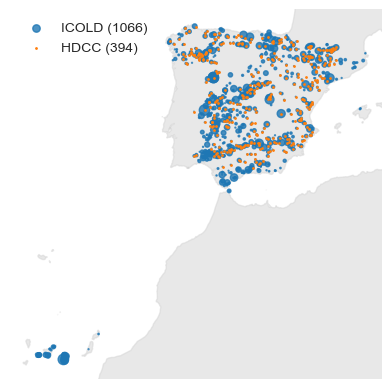

In [106]:
# import shapefile
icold = gpd.read_file(path_datasets / 'reservoirs/ICOLD/2023/ICOLD_ES.shp')
icold.reset_index(drop=True, inplace=True)

# convert units to MCM (hm3)
icold.Res_Vol /= 1000

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
icold.plot(markersize=icold.Res_Vol**.5, alpha=.8, ax=ax, label=f'ICOLD ({icold.shape[0]})')
hdcc.plot(markersize=1, ax=ax, label=f'HDCC ({hdcc.shape[0]})')
# ax.set_extent([-10, 4.5, 35.5, 44])
ax.legend(frameon=False)
ax.axis('off');

# # convert units to MCM (hm3)
# icold_es.Res_Vol /= 1000

# mask_volume = icold_es.Res_Vol > 10
# print(f'no. reservoirs in Spain with V > 100 hm3:\t{mask_volume.sum()}')

### Connect HDCC and ICOLD

In [147]:
# nearest neighbour in ICOLD for each point in HDCC
idx_hdcc, idx_icold = icold.sindex.nearest(hdcc.geometry, max_distance=.05)

# add ICOLD name and ID to the HDCC table
hdcc.drop(['ICOLD_ID', 'ICOLD_Name'], axis=1, inplace=True, errors='ignore')
idx_hdcc = hdcc.index[idx_hdcc]
icold['Local_ID'] = np.nan
icold.loc[idx_icold, 'Local_ID'] = idx_hdcc.values
icold.loc[idx_icold, 'HDCC_Name'] = hdcc.loc[idx_hdcc, 'Name'].values

In [146]:
# remove Local_ID from reservoirs whose name in ICOLD and HDCC doesn't match
mask_name = icold.Res_Name != icold.HDCC_Name
mask_id = ~icold.Local_ID.isnull()
icold.loc[mask_name & mask_id, 'Local_ID'] = np.nan
# icold.loc[mask_name & mask_id, ['Int_Code', 'Res_Name', 'Local_ID', 'HDCC_Name']]

There are 13 reservoirs in the HDCC database that are not included in ICOLD. There are 6 reservoirs where the connection between HDCC and ICOLD is dubious.

### Reservoir use

In [148]:
# count uses
uses = []
for ID in icold.index:
    try:
        uses = uses + list(icold.loc[ID, 'Purposes'])
    except:
        continue

np.unique(uses, return_counts=True)

(array(['C', 'H', 'I', 'R', 'S', 'T', 'X'], dtype='<U1'),
 array([ 48, 354, 505,   9, 411,   3,  88], dtype=int64))

In [149]:
rename_uses = {'C': 'flood',
               'I': 'irrigation',
               'H': 'hydropower',
               'F': 'aquaculture',
               'N': 'navigation',
               'R': 'recreation',
               'S': 'supply',
               'X': 'other',
               'T': 'tailings'}

icold['main_use'] = ''
icold['single_use'] = True

uses = list(rename_uses.values())
uses.sort()
icold[uses] = False

for ID in icold.index:
    if icold.loc[ID, 'Purposes'] is None:
        continue
    for i, key in enumerate(icold.loc[ID, 'Purposes']):
        use = rename_uses[key]
        if i == 0:
            icold.loc[ID, 'main_use'] = use
        icold.loc[ID, use] = True

# identify multi-purpose reservoirs
mask_multipurpose = icold[uses].sum(axis=1) > 1
icold.loc[mask_multipurpose, 'single_use'] = False

# # remove original 'Purposes' field
# icold.drop('Purposes', axis=1, inplace=True)

**Main use**

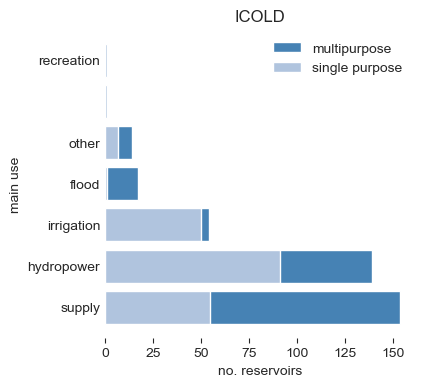

In [151]:
mask_singleuse = icold.single_use
# mask_hdcc = icold.Int_Code.isin(hdcc.ICOLD_ID.values)
mask_hdcc = ~icold.Local_ID.isnull()

use_summary_singlepurpose = icold.loc[mask_hdcc & mask_singleuse, 'main_use'].value_counts()
use_summary_multipurpose = icold.loc[mask_hdcc, 'main_use'].value_counts()

fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(use_summary_multipurpose.index, use_summary_multipurpose.values, color='steelblue', label='multipurpose')
ax.barh(use_summary_singlepurpose.index, use_summary_singlepurpose.values, color='lightsteelblue', label='single purpose')
ax.set(title='ICOLD',
       xlabel='no. reservoirs',
       ylabel='main use')
ax.tick_params(axis='y', length=0)
ax.legend(loc=1, frameon=False)
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);

# plt.savefig(path_out / 'reservoir_main_use.jpg', dpi=300, bbox_inches='tight');

**All uses**

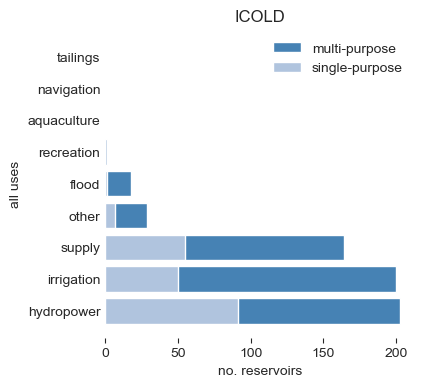

In [152]:
aux1 = icold.loc[mask_hdcc & mask_singleuse, uses].sum()
aux2 = icold.loc[mask_hdcc, uses].sum()
aux = pd.concat((aux1, aux2), axis=1)
aux.columns = ['singlepurpose', 'multipurpose']
aux.sort_values('multipurpose', ascending=False, inplace=True)
aux.dropna(axis=0, how='all', inplace=True)

fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(aux.index, aux.multipurpose, color='steelblue', label='multi-purpose')
ax.barh(aux.index, aux.singlepurpose, color='lightsteelblue', label='single-purpose')
ax.set(title='ICOLD',
       xlabel='no. reservoirs',
       ylabel='all uses')
ax.tick_params(axis='y', length=0)
ax.legend(loc=1, frameon=False)
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);

### Export

Interesting attributes in ICOLD:

* Altitude.
* Catch_area. Compare with CEDEX.
* Crest_Leng. Compare with CEDEX.
* Elec_Capac.
* Ene_Annual.
* Height.
* Irr_Area.
* Purposes
* Res_Area. Compare with CEDEX.
* Res_Leng.
* Res_Vol. Compare with CEDEX.
* Spill_Cap. Compare with CEDEX.
* Spill_type.
* Vol_flood.
* Year.

In [170]:
# attributes to be included from ICOLD
cols_icold = ['Altitude', 'Catch_Area', 'Crest_Leng', 'Dam_Name',
              'Elec_Capac', 'Ene_Annual',
              'Foundation', 'Height',
              'Irr_Area', 
              'Latitude', 'Longitude',
              'Res_Area', 'Res_Leng', 'Res_Name', 'Res_Vol', 'Resettled',
              'Spill_Cap', 'Spill_Type', 'Vol_flood', 'Year',
              'main_use', 'single_use', 'aquaculture', 'flood', 'hydropower', 'irrigation', 'navigation', 'other', 'recreation', 'supply', 'tailings', 'Local_ID']

In [171]:
mask_id = ~icold.Local_ID.isnull()

In [174]:
icold.loc[mask_id, cols_icold].set_index('Local_ID', drop=True).to_csv(path_out / 'attributes_ICOLD.csv')

## EFAS

In [175]:
path_EFAS = Path('Z:/nahaUsers/casadje/EFASv5/reservoirs/')

### Shapefile

In [284]:
# load EFAS reservoirs
efas = gpd.read_file(path_EFAS / 'reservoirs_EFAS5.shp')
efas.ResID = efas.ResID.astype(pd.Int64Dtype())
efas.set_index('ResID', inplace=True)

# filter reservoir in Spain
efas = efas.loc[efas.COUNTRY == 'Spain']

# correct dam names
efas.DAM_NAME.replace(np.nan, '', inplace=True)
names = []
for name in efas.DAM_NAME.str.upper():
    split = name.split('_')
    if len(split) == 2:
        names.append(split[0])
    elif len(split) > 2:
        names.append(' '.join(split[:-1]))
    else:
        names.append(name)
efas.DAM_NAME = names

# correct coordinates of Cenza reservoir
# efas.loc[3132, ['LON_ORG', 'LAT_ORG']] = [-7.1442, 42.1141]

# remove old reservoir "El Alisillo" (ResID = 3247)
efas.drop([3247], axis=0, inplace=True)

# convert coordinates into the original
efas = pd.DataFrame(efas)
efas[['LON_ORG', 'LAT_ORG']] = efas[['LON_ORG', 'LAT_ORG']].astype(float)
geometry = [Point(xy) for xy in zip(efas.LON_ORG, efas.LAT_ORG)]
efas = gpd.GeoDataFrame(efas, geometry=geometry, crs='epsg:4326')

# add EFAS reservoir parameters
EFAS_vars = {'rclim': 'Vc',
             'rflim': 'Vf',
             'rminq': 'Qmin',
             'rndq': 'Qnd',
             'rnlim': 'Vn',
             'rnormq': 'Qn',
             'rtstor': 'Vtotal'}

for file in path_EFAS.glob('r*.txt'):
    var = EFAS_vars[file.stem]
    serie = pd.read_csv(file, header=None, index_col=0, sep=' ').squeeze()
    efas[var] = serie.loc[efas.index]
# convert volumes to hm3
efas[['Vc', 'Vf', 'Vn', 'Vtotal']] /= 1e6

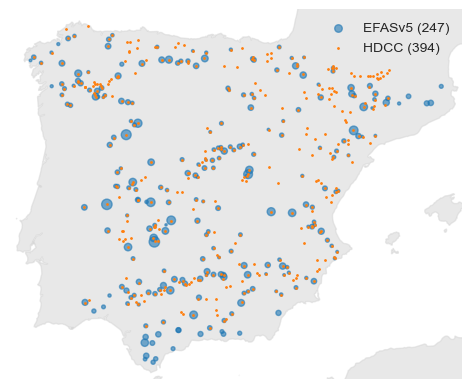

In [285]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
efas.plot(markersize=efas.Vtotal**.5, alpha=.6, ax=ax, label=f'EFASv5 ({efas.shape[0]})')
hdcc.plot(markersize=1, ax=ax, label=f'HDCC ({hdcc.shape[0]})')
# ax.set_extent([-10, 4.5, 35.5, 44])
ax.legend(frameon=False)
ax.axis('off');

### Raster

In [286]:
# load static map of reservoirs
efas_raster = xr.open_mfdataset(f'{path_EFAS}/res*.nc')['res'].compute()

# extract an array of reservoir ID
# ids = np.unique(glofas_raster.where(~glofas_raster.isnull(), drop=True))
# ids = ids[~np.isnan(ids) & (ids != -9999)]
# ids = ids.astype(int)
ids = efas.index.sort_values().tolist()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    try:
        cell = efas_raster.where(efas_raster == id, drop=True)
        lon.loc[dict(ResID=id)] = cell.lon.data[0]
        lat.loc[dict(ResID=id)] = cell.lat.data[0]
    except:
        lon = lon.where(lon.ResID != id, drop=True)
        lat = lat.where(lat.ResID != id, drop=True)
        
coords = xr.Dataset({'lon': lon, 'lat': lat})

  0%|          | 0/247 [00:00<?, ?it/s]

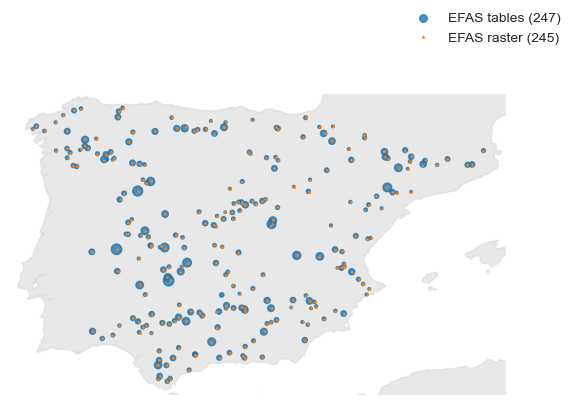

In [287]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
efas.plot(markersize=efas.Vtotal**.5, alpha=.8, ax=ax, label=f'EFAS tables ({efas.shape[0]})')
ax.scatter(coords['lon'].data, coords['lat'].data, s=1, label=f'EFAS raster ({len(coords.ResID)})')
# ax.set_extent([-10, 4.5, 35.5, 44])
fig.legend(frameon=False)
ax.set_aspect('equal')
ax.axis('off');

There's a reservoir missing in the EFAS raster (`ResID=3132`, Cenza). Apart from that, the reservoir Montoro III that I have created to replace "El Alisillo" is also missing.

### Connect HDCC and EFAS

In [288]:
# create fields for the ID and name in HDCC
efas[['Local_ID', 'HDCC_Name']] = np.nan

# find matches based on the name
mask_name = hdcc.Name.isin(efas.DAM_NAME)
for ID, name in hdcc.loc[mask_name, 'Name'].items():
    efas.loc[efas.DAM_NAME == name, ['Local_ID', 'HDCC_Name']] = ID, name
    # ResID = efas.loc[efas.DAM_NAME == name].index[0]
    # hdcc.loc[ID, ['ResID', 'EFAS_Name']] = ResID, name

# # find matches based on geographical proximity
# mask_id_efas = efas.Local_ID.isnull() #efas.index.difference(hdcc.ResID)
# mask_id_hdcc = hdcc.index.difference(efas.Local_ID.unique())
# idx_hdcc, idx_efas = efas.loc[mask_id_efas].sindex.nearest(hdcc.loc[mask_id_hdcc].geometry, max_distance=.025)
# idx_hdcc = hdcc.loc[mask_id_hdcc].index[idx_hdcc]
# idx_efas = efas.loc[mask_id_efas].index[idx_efas]
# efas.loc[idx_efas, ['Local_ID', 'HDCC_Name']] = idx_hdcc, hdcc.loc[idx_hdcc, 'Name'].values

### Export

In [292]:
# reindex
efas.reset_index(inplace=True)
efas.set_index('Local_ID', drop=True, inplace=True)

# rename columns
efas.rename(columns={'ACTIVE_FRO': 'YEAR'}, inplace=True)

# attributes to be included from EFAS
cols_efas = ['ResID', 'DAM_NAME', 'YEAR',
             # coordinates
             'LON_ORG', 'LAT_ORG', 'LisfloodX', 'LisfloodY',
             # LISFLOOD limits
             'Vc', 'Vf', 'Qmin', 'Qnd', 'Vn', 'Qn', 'Vtotal']

# export as CSV
efas.loc[~efas.index.isnull(), cols_efas].to_csv(path_out / 'attributes_EFAS.csv')